# Setup

In [4]:
import logging
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

from env import Environment
from logger import setup_custom_logger

# Variable declaration

In [5]:
logger = setup_custom_logger('easy21')
logger.setLevel(logging.WARN)

In [6]:
env = Environment(logger)

# Definitions

In [7]:
def dumb_policy(state):
    return 0 if state[1] < 15 else 1

In [8]:
def monte_carlo_prediction(policy, env, num_episodes, discount_factor=1.0):
    "Estimate value function using monte carlo first visit prediction algorithm."
    returns_count = defaultdict(float)
    V = defaultdict(float)
    
    max_steps = 100
    for i_episode in range(num_episodes):
        state = env.reset()
        episode = []
        
        for t_step in range(max_steps):
            action = policy(state)
            next_state, reward, done = env.step(state, action)
            episode.append((state, reward, action))
            state = next_state
            if done:
                break

        # First Occurrence monte Carlo
        states_in_episode = set(x[0] for x in episode)
        for state in states_in_episode:
            first_occurrence_idx = next(i for i, step in enumerate(episode) if step[0] == state)
            G = sum(discount_factor ** (i) * step[1] for i, step in enumerate(episode[first_occurrence_idx:]))
            returns_count[state] += 1
            V[state] += (G - V[state])/returns_count[state]

    return V  

In [18]:
def make_epsilon_greedy_policy(Q, N, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        N: A dictionary that maps from state -> counts.
            Each value is a numpy array of length nA (see below)
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    # Constant for calculating epsilon value
    N0 = 100
    def policy(state):
        epsilon = N0 / (N0 + np.sum(N[state]))
        A = np.full(nA, epsilon / nA)
        best_action = np.argmax(Q[state]) # id of most valuable action
        A[best_action] += 1 - epsilon
        return A
    
    return policy

In [19]:
def monte_carlo_control(env, num_episodes, discount_factor=1.0, max_steps=100, N0=100):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy. Epsilon value is calculated internally based on N0 value.
    
    Args:
        env: environment class object.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        max_steps: Maximum number of steps per episode.
        N0: Constant for calculating epsilon value.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    N = defaultdict(lambda: np.zeros(env.nA)) # Count of state-action pair occurrences
    Q = defaultdict(lambda: np.zeros(env.nA)) # Action-value function
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, N, env.nA)
    
    max_steps = 100
    for i_episode in range(num_episodes):
        if i_episode % 1000 == 0:
            print(f"Episode {i_episode}")
        
        state = env.reset()
        episode = []

        # Generate episode
        for t_step in range(max_steps):
            A = policy(state)
            action = np.random.choice(env.nA, p=A)
            next_state, reward, done = env.step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Update Q-values using first-visit method
        first_visits = {}
        for t, (state, action, reward) in enumerate(episode):
            if (state, action) not in first_visits:
                first_visits[(state, action)] = t

        for (state, action), first_visit_t in first_visits.items():
            G = sum(reward * (discount_factor ** i) for i, (_, _, reward) in enumerate(episode[first_visit_t:]))
            N[state][action] += 1
            alpha = 1 / N[state][action]
            Q[state][action] += alpha * (G - Q[state][action])

        # Policy is updated automatically because N, Q are dicts.
        # policy = make_epsilon_greedy_policy(Q, N, env.nA)

    return Q, policy

In [11]:
def visualize_value_function_2d(value_function, title):
    # Define the grid size for dealer score (1-10) and player score (1-21)
    dealer_scores = range(1, 11)   # Dealer score from 1 to 10
    player_scores = range(1, 22)   # Player score from 1 to 21

    # Create a 2D grid for value function values
    value_grid = np.zeros((len(player_scores), len(dealer_scores)))

    # Fill the value grid with the values from the value function
    for dealer in dealer_scores:
        for player in player_scores:
            value_grid[player - 1, dealer - 1] = value_function[(dealer, player)]

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(value_grid, cmap='coolwarm', origin='lower', extent=[1, 10, 1, 21])
    
    # Add labels and title
    plt.colorbar(label='Value Function')
    plt.title(title)
    plt.xlabel('Dealer Score')
    plt.ylabel('Player Score')
    
    # Show the heatmap
    plt.show()


In [12]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def visualize_value_function_3d(value_function, title):
    # Define the grid size for dealer score (1-10) and player score (1-21)
    dealer_scores = np.arange(1, 11)   # Dealer score from 1 to 10
    player_scores = np.arange(1, 22)   # Player score from 1 to 21

    # Create a meshgrid for dealer and player scores
    dealer_grid, player_grid = np.meshgrid(dealer_scores, player_scores)

    # Create a 2D array to store the value function values
    value_grid = np.zeros(dealer_grid.shape)

    # Fill the value grid with values from the value function
    for dealer in dealer_scores:
        for player in player_scores:
            value_grid[player - 1, dealer - 1] = value_function[(dealer, player)]

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surface = ax.plot_surface(dealer_grid, player_grid, value_grid, cmap='coolwarm', edgecolor='none')

    # Add a color bar to indicate value
    fig.colorbar(surface, ax=ax, label='Value Function')

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('Dealer Score')
    ax.set_ylabel('Player Score')
    ax.set_zlabel('Value')

    # Show the plot
    plt.show()


# Test environment

In [10]:
state = env.reset()
print(state)

(7, 9)


In [11]:
state, reward, is_terminal = env.step(state, 0)
print(f"State: {state}\nReward: {reward}\nIs terminal: {is_terminal}")

State: (7, 15)
Reward: 0
Is terminal: False


In [122]:
state, reward, is_terminal = env.step(state, 1)
print(f"State: {state}\nReward: {reward}\nIs terminal: {is_terminal}")

easy21 - INFO - Dealer card: 10 black
easy21 - INFO - Dealer card: 10 red
easy21 - INFO - Dealer card: 1 red
easy21 - INFO - Dealer card: 10 black
easy21 - INFO - Dealer card: 10 red
easy21 - INFO - Dealer card: 8 red


State: (-4, 19)
Reward: 1
Is terminal: True


# Other

In [13]:
# Training process
num_episodes = 20
max_steps = 100
history = []
for i_episode in range(num_episodes):
    state = env.reset()
    history.append([])
    print(f"{i_episode}) Player score: {state[1]}, Dealer score: {state[0]}")
    for t_step in range(max_steps):
        action = policy(state)
        next_state, reward, done = env.step(state, action)
        print(f"{i_episode}) Player score: {next_state[1]}, Dealer score: {next_state[0]}")
        history[-1].append((state, action, reward, next_state))
        state = next_state
        if done:
            print(f"Game finished, reward: {reward}")
            break

0) Player score: 10, Dealer score: 1
0) Player score: 18, Dealer score: 1
0) Player score: 18, Dealer score: -1
Game finished, reward: 1
1) Player score: 6, Dealer score: 7
1) Player score: 11, Dealer score: 7
1) Player score: 1, Dealer score: 7
1) Player score: 4, Dealer score: 7
1) Player score: -2, Dealer score: 7
Game finished, reward: -1
2) Player score: 2, Dealer score: 8
2) Player score: -3, Dealer score: 8
Game finished, reward: -1
3) Player score: 4, Dealer score: 7
3) Player score: -4, Dealer score: 7
Game finished, reward: -1
4) Player score: 8, Dealer score: 6
4) Player score: 18, Dealer score: 6
4) Player score: 18, Dealer score: 20
Game finished, reward: -1
5) Player score: 6, Dealer score: 7
5) Player score: 11, Dealer score: 7
5) Player score: 2, Dealer score: 7
5) Player score: 5, Dealer score: 7
5) Player score: 10, Dealer score: 7
5) Player score: 2, Dealer score: 7
5) Player score: 11, Dealer score: 7
5) Player score: 16, Dealer score: 7
5) Player score: 16, Dealer 

In [27]:
policy = lambda state: 0 if state[1] < 12 else 1
V_10000 = monte_carlo_prediction(policy, env, num_episodes=100000)
# pprint(V)

# Visualizations

In [20]:
Q, policy = monte_carlo_control(env, 100_000)

Episode 0
Episode 1000
Episode 2000
Episode 3000
Episode 4000
Episode 5000
Episode 6000
Episode 7000
Episode 8000
Episode 9000
Episode 10000
Episode 11000
Episode 12000
Episode 13000
Episode 14000
Episode 15000
Episode 16000
Episode 17000
Episode 18000
Episode 19000
Episode 20000
Episode 21000
Episode 22000
Episode 23000
Episode 24000
Episode 25000
Episode 26000
Episode 27000
Episode 28000
Episode 29000
Episode 30000
Episode 31000
Episode 32000
Episode 33000
Episode 34000
Episode 35000
Episode 36000
Episode 37000
Episode 38000
Episode 39000
Episode 40000
Episode 41000
Episode 42000
Episode 43000
Episode 44000
Episode 45000
Episode 46000
Episode 47000
Episode 48000
Episode 49000
Episode 50000
Episode 51000
Episode 52000
Episode 53000
Episode 54000
Episode 55000
Episode 56000
Episode 57000
Episode 58000
Episode 59000
Episode 60000
Episode 61000
Episode 62000
Episode 63000
Episode 64000
Episode 65000
Episode 66000
Episode 67000
Episode 68000
Episode 69000
Episode 70000
Episode 71000
Episo

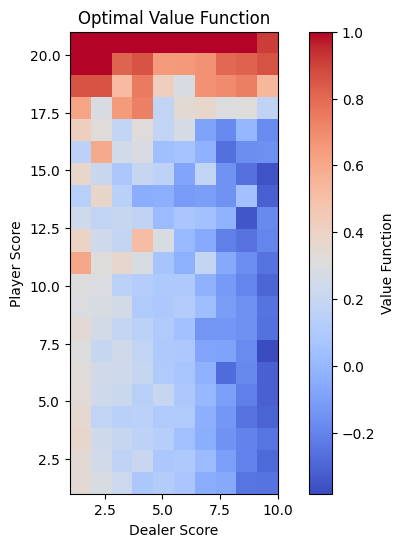

In [21]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
visualize_value_function_2d(V, title="Optimal Value Function")

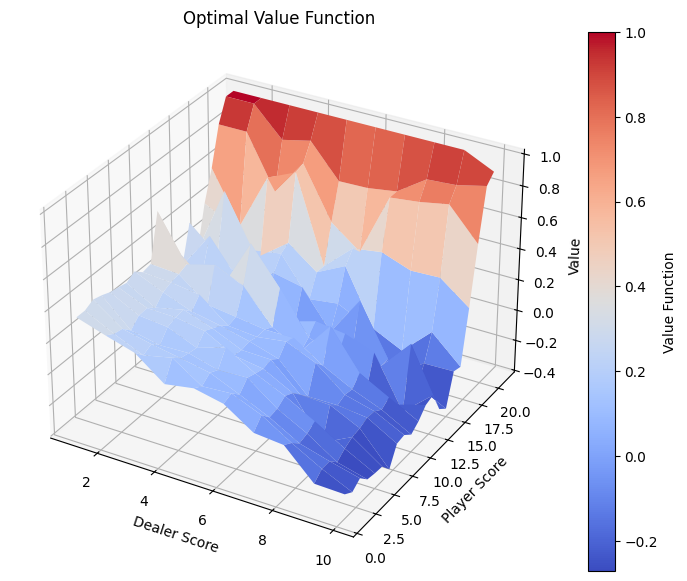

In [22]:
visualize_value_function_3d(V, title="Optimal Value Function")

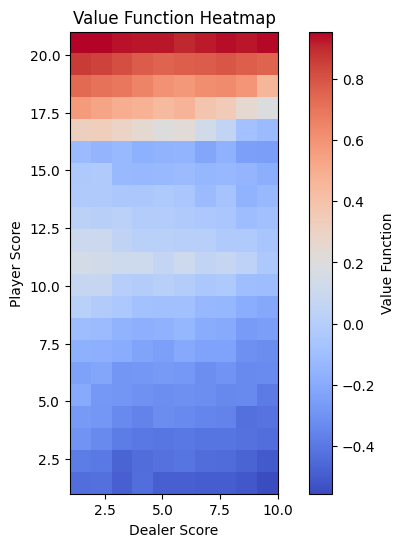

In [28]:
visualize_value_function(V_10000)

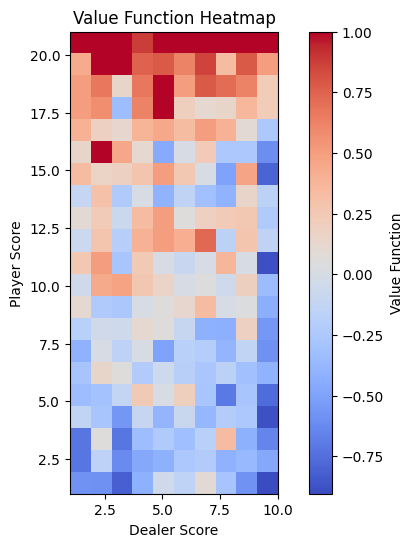

In [20]:
visualize_value_function(V_1000)

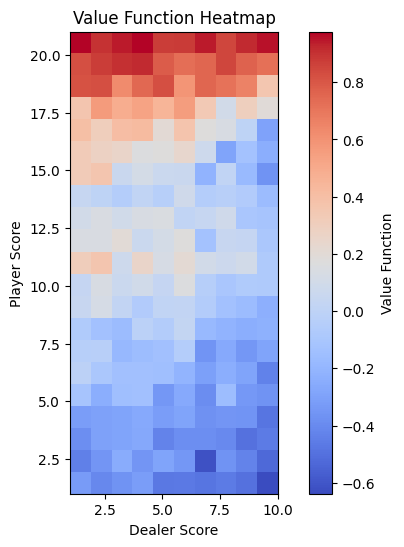

In [22]:
visualize_value_function(V_10000)

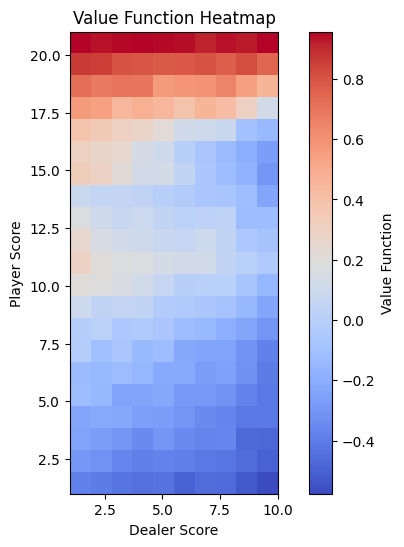

In [24]:
visualize_value_function(V_100000)

# To Do

1. Implement TD